In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time
import random
import pandas as pd
import openpyxl

In [26]:
N_x = 81
N_y = 81

x_l = 0
y_b = 0
x_r = 1
y_t = 1

N_t = 500000
dt = 0.00001

f_lim = 1

# material params:- RT-35
k_therm = 0.2
L = 160000
Cp = 2000
rho = 800 
T_solidus = 305
T_liquidus = 313

### Assumed boundary conditions ####
q = 450

#### Normalising coeffs #####
T_change = 0.35
# T_change = 0.25
delta_x = 0.01
delta_y = 0.01
# delta_T = (1 - T_change)*(T_liquidus - T_solidus)/T_change
delta_T = (T_liquidus - T_solidus)/T_change

#### k1 ###
k1 = k_therm/(rho*Cp*delta_x**2)*600

### k2 ###
k2 = k_therm/(rho*(Cp+L/(T_liquidus - T_solidus))*delta_x**2)*600

#### q_bnorm #####
q_norm = q*delta_x/(k_therm*delta_T)

print('k1 = ',k1,' k2 = ', k2, ' q_norm = ', q_norm)

cfd_check = k1*dt/( (x_r-x_l)/(N_x-1) )**2
print('cfd_check = ', cfd_check)

k1 =  0.75  k2 =  0.06818181818181818  q_norm =  0.9843749999999999
cfd_check =  0.047999999999999994


In [11]:
# X, Y matrix
X = np.linspace(x_l,x_r,N_x)
dx = X[1] - X[0]
X = np.tile(X,N_y)
X = np.reshape(X, (N_x,N_y))

Y = np.linspace(y_b,y_t,N_y)
dy = Y[1] - Y[0]
Y = np.repeat(Y,N_x)
Y = np.reshape(Y, (N_x,N_y))

# liquid fraction, battery and initial temperature matrix
f = np.zeros((N_x,N_y))
T = np.zeros((N_x,N_y))

In [12]:
aN = np.zeros((N_x,N_y))
aS = np.zeros((N_x,N_y))
aE = np.zeros((N_x,N_y))
aW = np.zeros((N_x,N_y))
aP = np.zeros((N_x,N_y))
flag = np.zeros((N_x,N_y))

for i in range(N_x):
    for j in range(N_y):
        
        if Y[i][j]!=y_t:
            aN[i][j] = k2*dt/dy**2
            
        if Y[i][j]!=y_b:
            aS[i][j] = k2*dt/dy**2
            
        if X[i][j]!=x_l:
            aW[i][j] = k2*dt/dx**2
            
        if X[i][j]!=x_r:
            aE[i][j] = k2*dt/dx**2
            
        aP[i][j] = 1 - (aN[i][j] + aS[i][j] + aW[i][j] + aE[i][j])

In [14]:
storage_interval = 10000

T_str = []
T_str.append(np.copy(T))
T_new = np.copy(T)

f_str = []
f_str.append(np.copy(f))
f_new = np.copy(f)      

for t in range(N_t):
    
    if t%10000==0:
        print('t = ',(t+1)*dt)
    
    T = np.copy(T_new)
    f = np.copy(f_new)

    # Temperature Update
    for i in range(N_y):
        for j in range(N_x):

            if ( X[i][j]!=x_l and X[i][j]!=x_r and Y[i][j]!=y_t and Y[i][j]!=y_b ):
                
                T_new[i][j] = ( aN[i][j]*T[i+1][j] + aS[i][j]*T[i-1][j] + 
                                   aW[i][j]*T[i][j-1] + aE[i][j]*T[i][j+1] + aP[i][j]*T[i][j] )
                
                f_new[i][j] = T_new[i][j]/T_change

    # LEFT BOUNDARY
    for i in range(N_y):
        T_new[i][0] = q_norm*dx + T_new[i][1]
        f_new[i][0] = T_new[i][0]/T_change

    # BOTTOM BOUNDARY
    for j in range(1, N_x):
        T_new[0][j] = T_new[1][j]
        f_new[0][j] = T_new[0][j]/T_change

    # TOP BOUNDARY
    for j in range(1, N_x):
        T_new[N_y-1][j] = T_new[N_y-2][j]
        f_new[N_y-1][j] = T_new[N_y-1][j]/T_change

    # RIGHT BOUNDARY
    for i in range(N_y):
        T_new[i][N_x-1] = T_new[i][N_x-2]
        f_new[i][N_x-1] = T_new[i][N_x-1]/T_change

    ######### Liquid Fraction Update #########
    for i in range(N_y):
        for j in range(N_x):
        
            if T_new[i][j]>=T_change or f_new[i][j]>=1:

                f_new[i][j] = 1

                if Y[i][j]!=y_t:
                    aN[i][j] = k1*dt/dy**2

                if Y[i][j]!=y_b:
                    aS[i][j] = k1*dt/dy**2

                if X[i][j]!=x_l:
                    aW[i][j] = k1*dt/dx**2

                if X[i][j]!=x_r:
                    aE[i][j] = k1*dt/dx**2

                aP[i][j] = 1 - (aN[i][j] + aS[i][j] + aW[i][j] + aE[i][j])

    if (t+1)%10000==0:
        T_str.append(np.copy(T_new))
        f_str.append(np.copy(f_new))

t =  1e-05
t =  0.10001
t =  0.20001000000000002
t =  0.30001
t =  0.40001000000000003
t =  0.5000100000000001
t =  0.60001
t =  0.70001
t =  0.8000100000000001
t =  0.9000100000000001
t =  1.00001
t =  1.1000100000000002
t =  1.20001
t =  1.30001
t =  1.4000100000000002
t =  1.50001
t =  1.6000100000000002
t =  1.7000100000000002
t =  1.80001
t =  1.9000100000000002
t =  2.00001
t =  2.10001
t =  2.2000100000000002
t =  2.3000100000000003
t =  2.40001
t =  2.50001
t =  2.60001
t =  2.7000100000000002
t =  2.8000100000000003
t =  2.9000100000000004
t =  3.00001
t =  3.10001
t =  3.2000100000000002
t =  3.3000100000000003
t =  3.4000100000000004
t =  3.50001
t =  3.60001
t =  3.7000100000000002
t =  3.8000100000000003
t =  3.9000100000000004
t =  4.0000100000000005
t =  4.10001
t =  4.200010000000001
t =  4.30001
t =  4.40001
t =  4.5000100000000005
t =  4.60001
t =  4.700010000000001
t =  4.80001
t =  4.90001


C:\Users\USER\AppData\Local\Temp\ipykernel_5544\2480104396.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

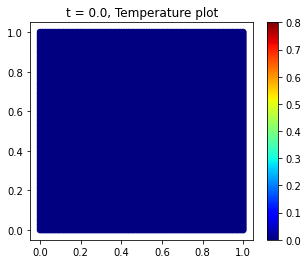

<Figure size 432x288 with 0 Axes>

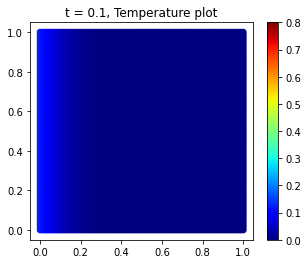

<Figure size 432x288 with 0 Axes>

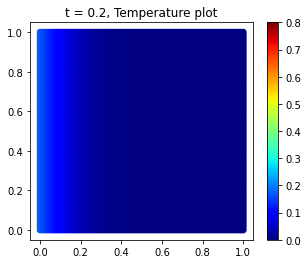

<Figure size 432x288 with 0 Axes>

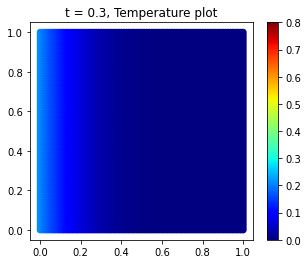

<Figure size 432x288 with 0 Axes>

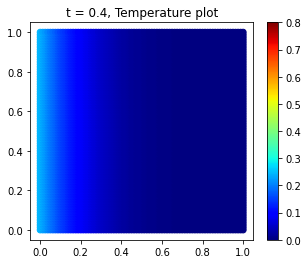

<Figure size 432x288 with 0 Axes>

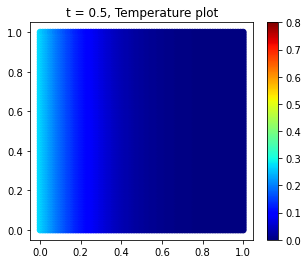

<Figure size 432x288 with 0 Axes>

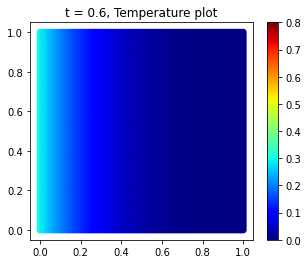

<Figure size 432x288 with 0 Axes>

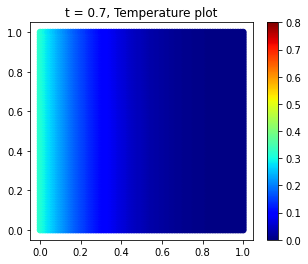

<Figure size 432x288 with 0 Axes>

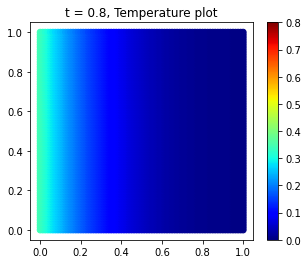

<Figure size 432x288 with 0 Axes>

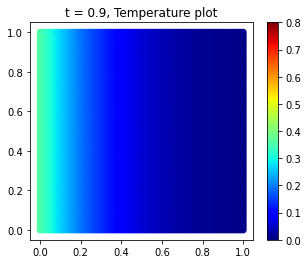

<Figure size 432x288 with 0 Axes>

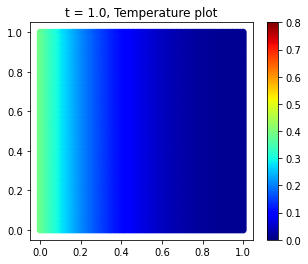

<Figure size 432x288 with 0 Axes>

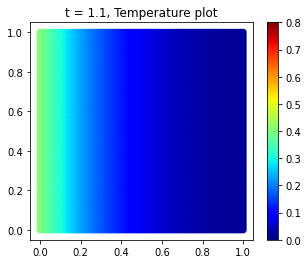

<Figure size 432x288 with 0 Axes>

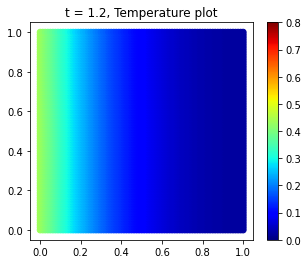

<Figure size 432x288 with 0 Axes>

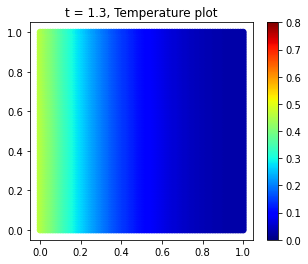

<Figure size 432x288 with 0 Axes>

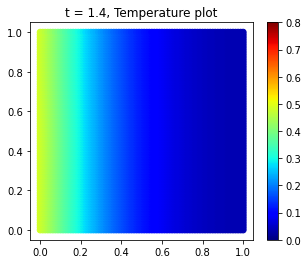

<Figure size 432x288 with 0 Axes>

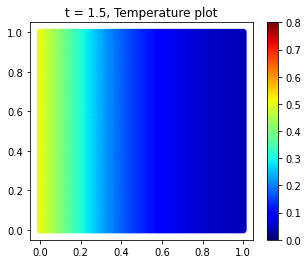

<Figure size 432x288 with 0 Axes>

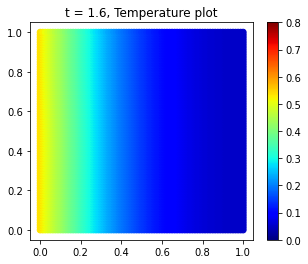

<Figure size 432x288 with 0 Axes>

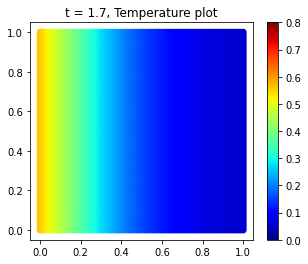

<Figure size 432x288 with 0 Axes>

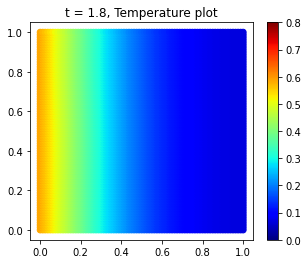

<Figure size 432x288 with 0 Axes>

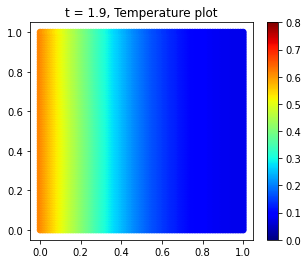

<Figure size 432x288 with 0 Axes>

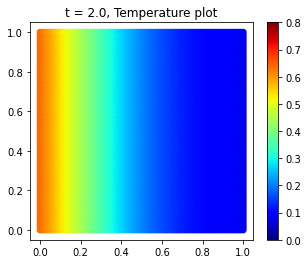

<Figure size 432x288 with 0 Axes>

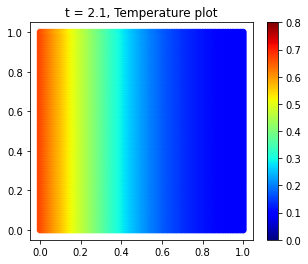

<Figure size 432x288 with 0 Axes>

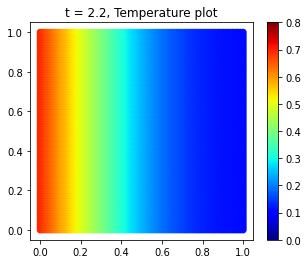

<Figure size 432x288 with 0 Axes>

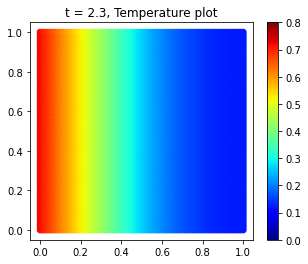

<Figure size 432x288 with 0 Axes>

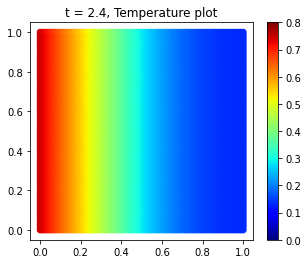

<Figure size 432x288 with 0 Axes>

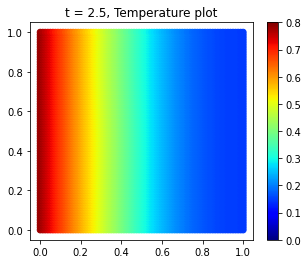

<Figure size 432x288 with 0 Axes>

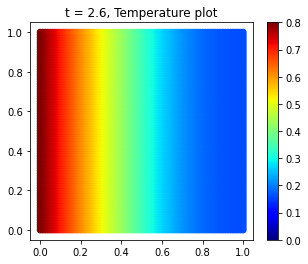

<Figure size 432x288 with 0 Axes>

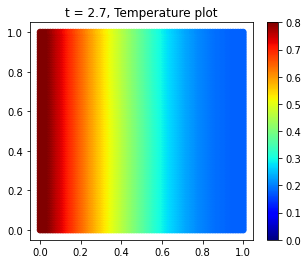

<Figure size 432x288 with 0 Axes>

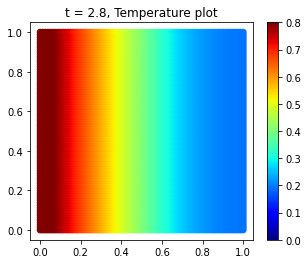

<Figure size 432x288 with 0 Axes>

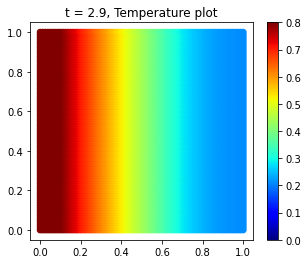

<Figure size 432x288 with 0 Axes>

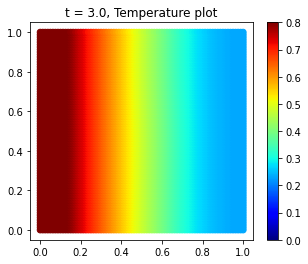

<Figure size 432x288 with 0 Axes>

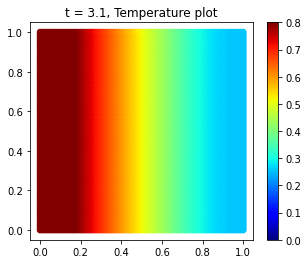

<Figure size 432x288 with 0 Axes>

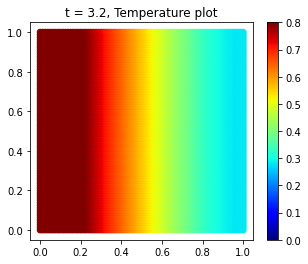

<Figure size 432x288 with 0 Axes>

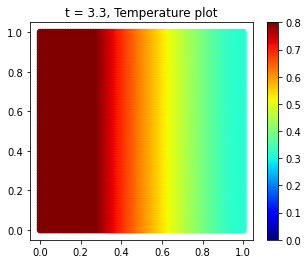

<Figure size 432x288 with 0 Axes>

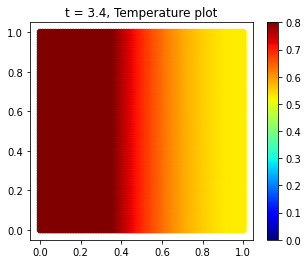

<Figure size 432x288 with 0 Axes>

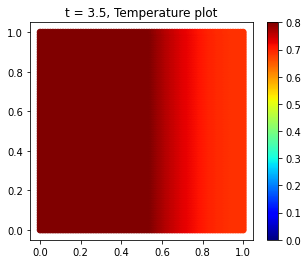

<Figure size 432x288 with 0 Axes>

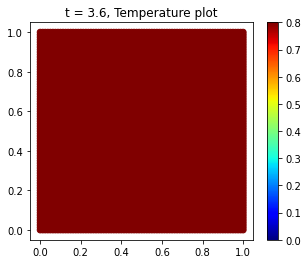

<Figure size 432x288 with 0 Axes>

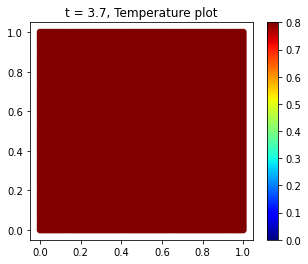

<Figure size 432x288 with 0 Axes>

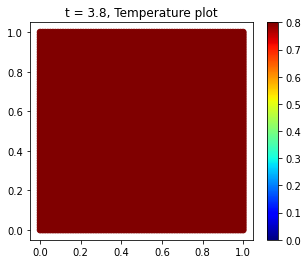

<Figure size 432x288 with 0 Axes>

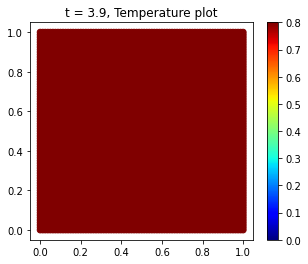

<Figure size 432x288 with 0 Axes>

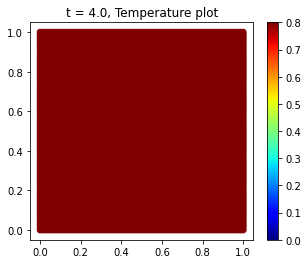

<Figure size 432x288 with 0 Axes>

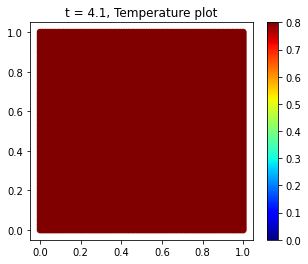

<Figure size 432x288 with 0 Axes>

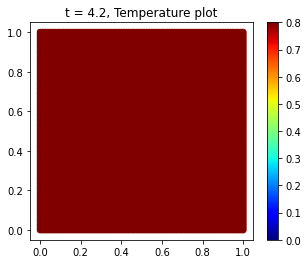

<Figure size 432x288 with 0 Axes>

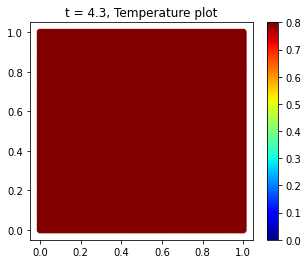

<Figure size 432x288 with 0 Axes>

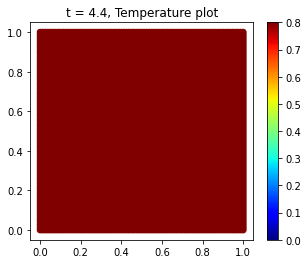

<Figure size 432x288 with 0 Axes>

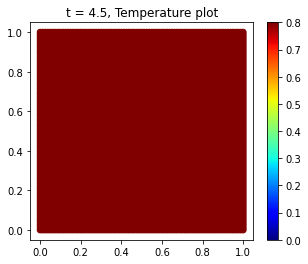

<Figure size 432x288 with 0 Axes>

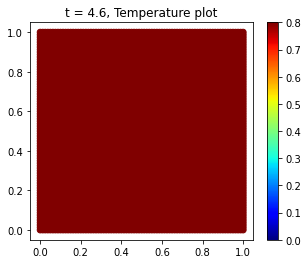

<Figure size 432x288 with 0 Axes>

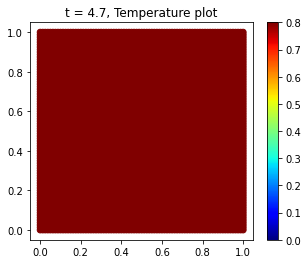

<Figure size 432x288 with 0 Axes>

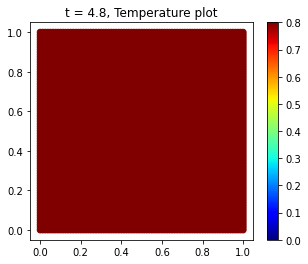

<Figure size 432x288 with 0 Axes>

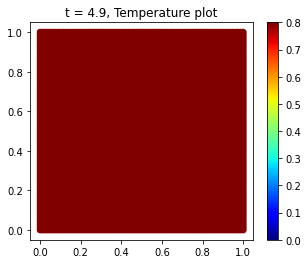

<Figure size 432x288 with 0 Axes>

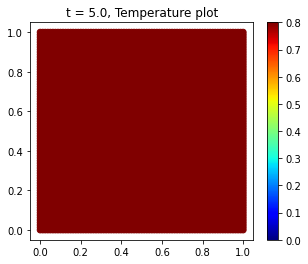

In [16]:
# Temperature plots
storage_interval = 10000
k = 0
for i in range(len(T_str)):
    
    plt.figure()
    plt.figure(figsize=(5,4))
    sc = plt.scatter(X, Y, c = T_str[i], cmap=plt.cm.jet)
    plt.colorbar(sc)
    plt.clim(0, 0.8)
    plt.title('t = '+ str(round(i*storage_interval*dt, 2)) +', Temperature plot')

plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_5544\4109055240.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

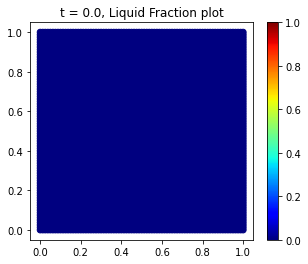

<Figure size 432x288 with 0 Axes>

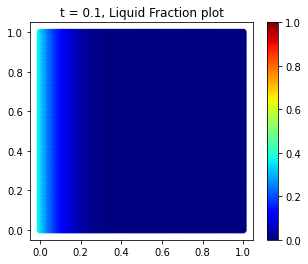

<Figure size 432x288 with 0 Axes>

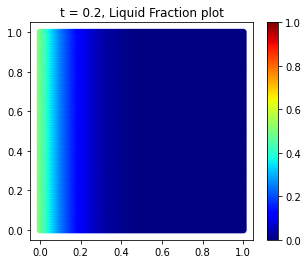

<Figure size 432x288 with 0 Axes>

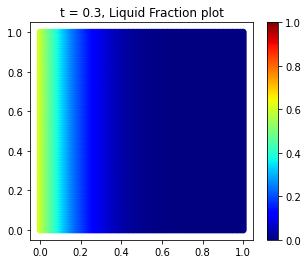

<Figure size 432x288 with 0 Axes>

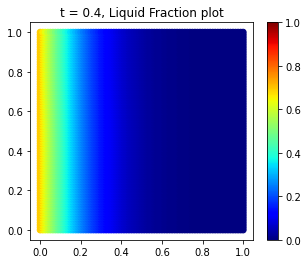

<Figure size 432x288 with 0 Axes>

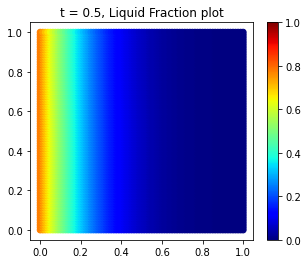

<Figure size 432x288 with 0 Axes>

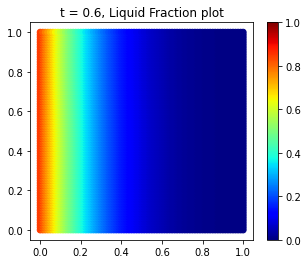

<Figure size 432x288 with 0 Axes>

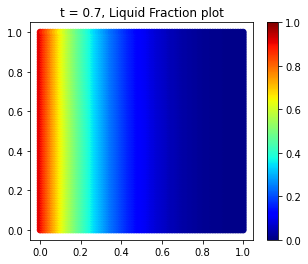

<Figure size 432x288 with 0 Axes>

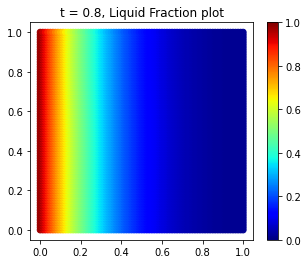

<Figure size 432x288 with 0 Axes>

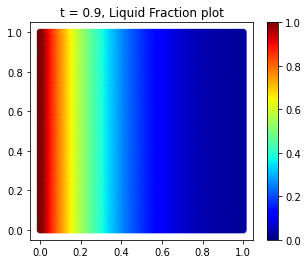

<Figure size 432x288 with 0 Axes>

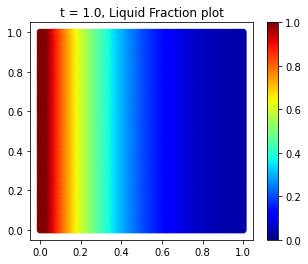

<Figure size 432x288 with 0 Axes>

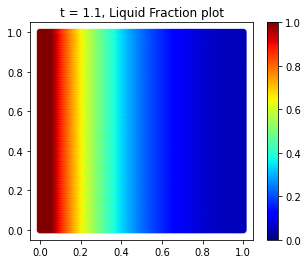

<Figure size 432x288 with 0 Axes>

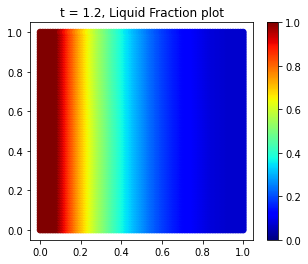

<Figure size 432x288 with 0 Axes>

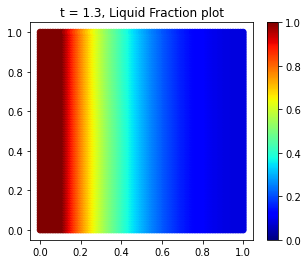

<Figure size 432x288 with 0 Axes>

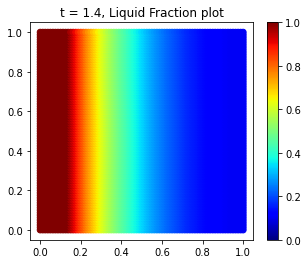

<Figure size 432x288 with 0 Axes>

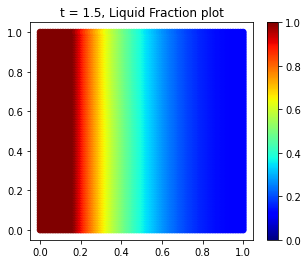

<Figure size 432x288 with 0 Axes>

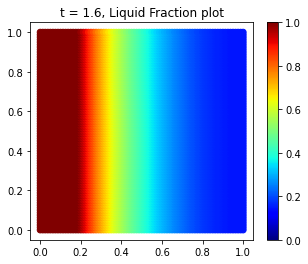

<Figure size 432x288 with 0 Axes>

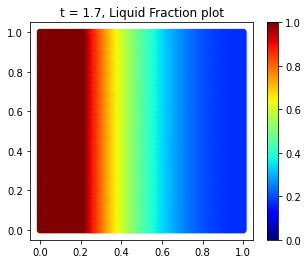

<Figure size 432x288 with 0 Axes>

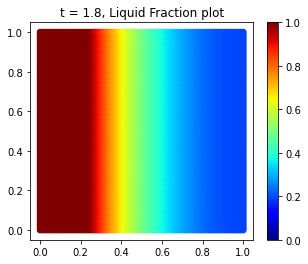

<Figure size 432x288 with 0 Axes>

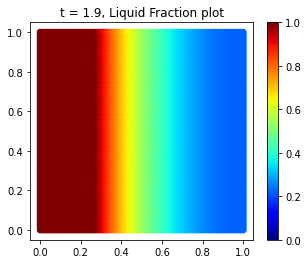

<Figure size 432x288 with 0 Axes>

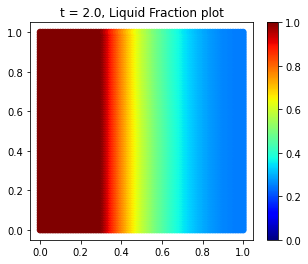

<Figure size 432x288 with 0 Axes>

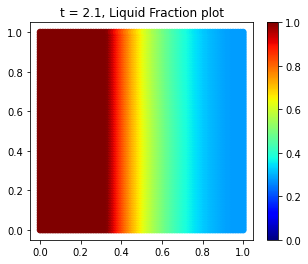

<Figure size 432x288 with 0 Axes>

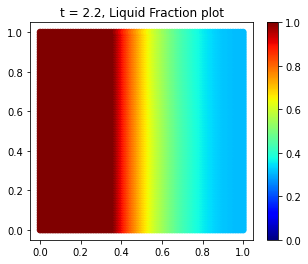

<Figure size 432x288 with 0 Axes>

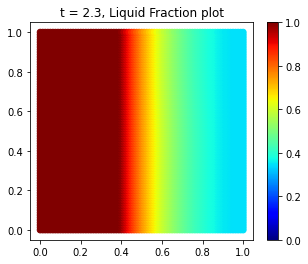

<Figure size 432x288 with 0 Axes>

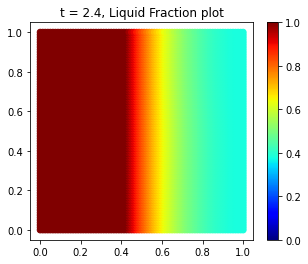

<Figure size 432x288 with 0 Axes>

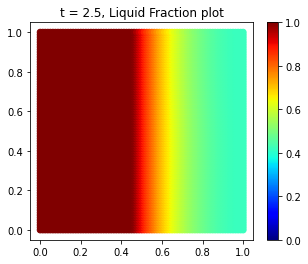

<Figure size 432x288 with 0 Axes>

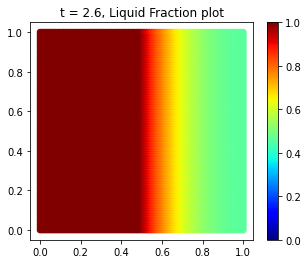

<Figure size 432x288 with 0 Axes>

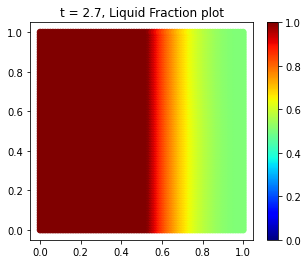

<Figure size 432x288 with 0 Axes>

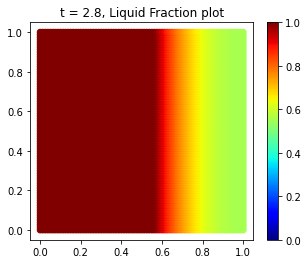

<Figure size 432x288 with 0 Axes>

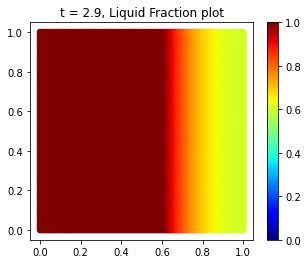

<Figure size 432x288 with 0 Axes>

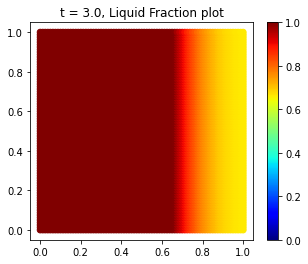

<Figure size 432x288 with 0 Axes>

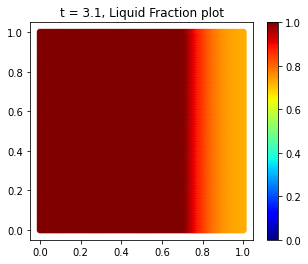

<Figure size 432x288 with 0 Axes>

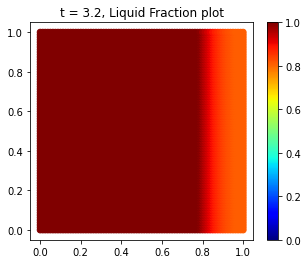

<Figure size 432x288 with 0 Axes>

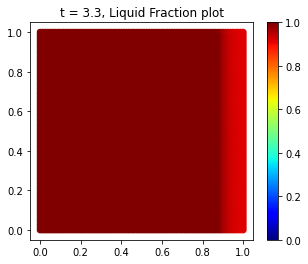

<Figure size 432x288 with 0 Axes>

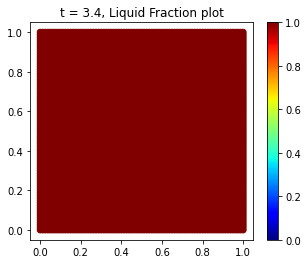

<Figure size 432x288 with 0 Axes>

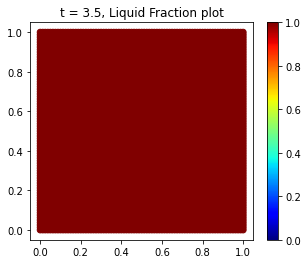

<Figure size 432x288 with 0 Axes>

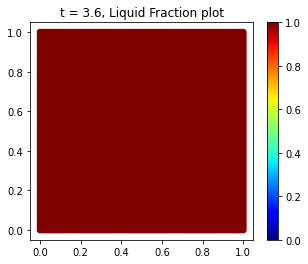

<Figure size 432x288 with 0 Axes>

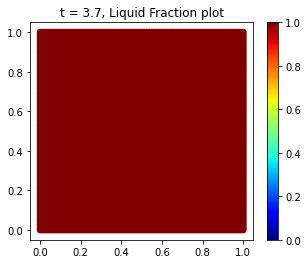

<Figure size 432x288 with 0 Axes>

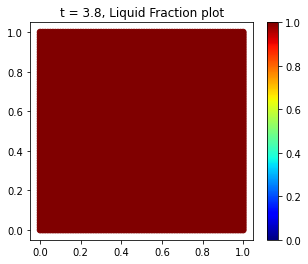

<Figure size 432x288 with 0 Axes>

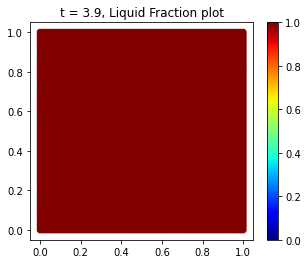

<Figure size 432x288 with 0 Axes>

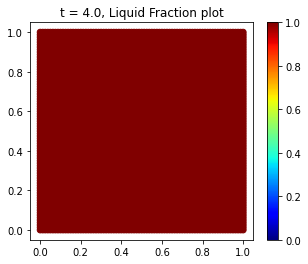

<Figure size 432x288 with 0 Axes>

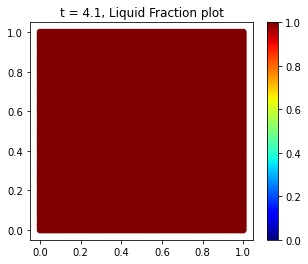

<Figure size 432x288 with 0 Axes>

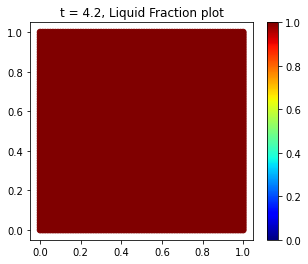

<Figure size 432x288 with 0 Axes>

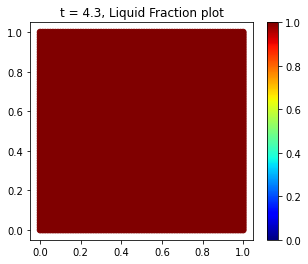

<Figure size 432x288 with 0 Axes>

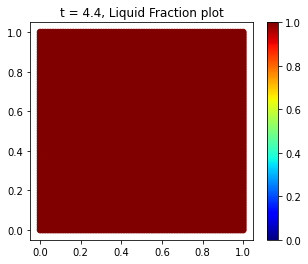

<Figure size 432x288 with 0 Axes>

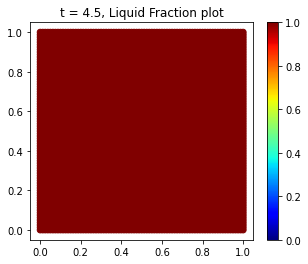

<Figure size 432x288 with 0 Axes>

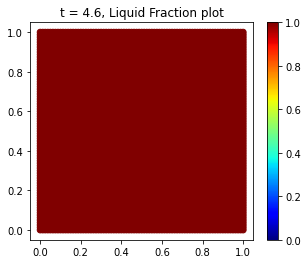

<Figure size 432x288 with 0 Axes>

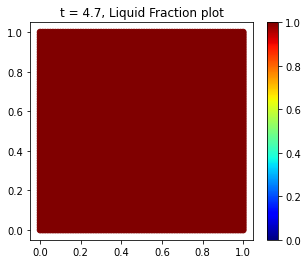

<Figure size 432x288 with 0 Axes>

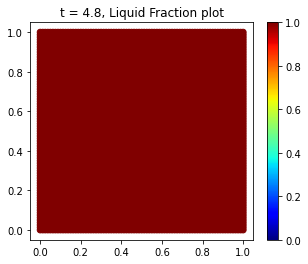

<Figure size 432x288 with 0 Axes>

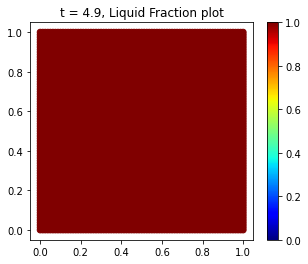

<Figure size 432x288 with 0 Axes>

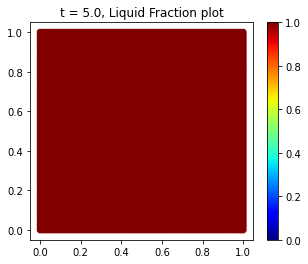

In [17]:
# Liquid Fraction plots
k = 0
for i in range(len(T_str)):
    
    plt.figure()
    plt.figure(figsize=(5,4))
    sc = plt.scatter(X, Y, c = f_str[i], cmap=plt.cm.jet)
    plt.colorbar(sc)
    plt.clim(0, 1)
    plt.title('t = '+  str(round(i*storage_interval*dt, 2)) +', Liquid Fraction plot')

plt.show()

In [15]:
# Store arrays in excel file

workbook = openpyxl.Workbook()
i = 0
for arr in T_str:
    # Create two sheets in the workbook
    sheet = workbook.create_sheet(title="t = "+ str(round(i*storage_interval*dt, 2)))
    # Populate the first sheet with data from the first array
    array = arr.tolist()
    for row in array:
        sheet.append(row)
    i = i+1

# Save the workbook to the specified file
file_name = "2d_1side_heating_2.xlsx"
workbook.save(file_name)
print(f"Data saved to {file_name}")


Data saved to 2d_1side_heating_2.xlsx


In [25]:
T_str[35]

array([[1.20473584, 1.19244192, 1.18027179, ..., 0.68588011, 0.68570308,
        0.68570308],
       [1.20474661, 1.19244192, 1.18027179, ..., 0.68588011, 0.68570308,
        0.68570308],
       [1.20474661, 1.19244192, 1.18027179, ..., 0.68588011, 0.68570308,
        0.68570308],
       ...,
       [1.20474661, 1.19244192, 1.18027179, ..., 0.68588011, 0.68570308,
        0.68570308],
       [1.20474661, 1.19244192, 1.18027179, ..., 0.68588011, 0.68570308,
        0.68570308],
       [1.20473584, 1.19244192, 1.18027179, ..., 0.68588011, 0.68570308,
        0.68570308]])

In [9]:
# # Data for creating graphs
# x = X[0]
# T = []
# for i in range(25):
#     T.append(T_str[-1][i][i])
# # T = T_str[-1][16]
# df = pd.DataFrame(list(zip(x, T)), columns = ['x', 'Temperature'])
# df
# df.to_excel("cfd_2sideflux_diagonal.xlsx")